In [1]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Import Statsmodel Libraries
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import scipy.stats as stats
import statsmodels.stats.api as sms


#Import sklearn  Libraries
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from IPython.display import display_html


#Set Display Options for Jupyter
pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import pickle
with open('regression_Data_xref.pickle', 'rb') as file:
    df_Target_Homes_For_xref = pickle.load(file)

# Mics Supporting Functions

In [2]:
#sklearn
def CreateTrainTestSplit(df, columns):
    listofSplitTrain_DFs = []
    
    X = df[columns]
    y = df['log_price']
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    X_train_No_ID = X_train.drop(['id'], axis = 1)
    
    X_test_No_ID = X_test.drop(['id'], axis = 1)
    
    listofSplitTrain_DFs.append(X_train)
    listofSplitTrain_DFs.append(X_test)
    listofSplitTrain_DFs.append(y_train)
    listofSplitTrain_DFs.append(y_test)
    listofSplitTrain_DFs.append(X_train_No_ID)
    listofSplitTrain_DFs.append(X_test_No_ID)
    
    return listofSplitTrain_DFs

def CreateModel_SK(X_train_No_ID, X_test_No_ID, y_train, y_test):
    listofValues = []
    listofAdjR = []
    listofdfs = []
  
    print(len(X_train_No_ID), len(X_test_No_ID), len(y_train), len(y_test))
    
    #Sklearn Features, Create Model
    linreg = LinearRegression()
    linreg.fit(X_train_No_ID, y_train)

    
    #Run Test
    y_hat_train = linreg.predict(X_train_No_ID)
    y_hat_test = linreg.predict(X_test_No_ID)
    
    # Collect Data into dataframe
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    
    train_R2 = round(linreg.score(X_train_No_ID,y_train),3)
    test_R2 = round(linreg.score(X_test_No_ID,y_test),3)
    
    listofAdjR.append(["train_R2",train_R2])
    listofAdjR.append(["test_R2",test_R2])
    df_listofAdjR = pd.DataFrame(listofAdjR, columns =['Measure', "Value"])
    df_listofAdjR.Value = df_listofAdjR.Value.apply(lambda x : "{:.3f}".format(x))
    
    listofValues.append(["train_mse", train_mse])
    listofValues.append(["test_mse",test_mse])
    listofValues.append(["intercept",linreg.intercept_])
    modelCoefficients = list(zip(X_train_No_ID.columns, linreg.coef_))
    listofValues = listofValues + modelCoefficients
    
    df = pd.DataFrame(listofValues, columns =['Measure', "Value"])
#     df.Value = df.Value.apply(lambda x : "{:,.0f}".format(x))
    
    
    df_listofAdjR1 = df_listofAdjR.append(df, ignore_index=True)
        
    return df_listofAdjR1, y_hat_train, y_hat_test

#StatsModel
def CreateModel_stats (y ,X_Train, Target_Features):
    predictors = X_Train[Target_Features]
    predictors_int = sm.add_constant(predictors)
    model = sm.OLS(y,predictors_int).fit()
    residuals = model.resid 
    return  model.summary(), residuals

def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

def RunQQplot (df_features, y_hat_data, NameOfPlot):
    df_features_copy = df_features.copy()
    
    df_features_copy.insert(0, 'log_price', y_hat_data)
    
    f = formula_from_cols(df_features_copy, "log_price")

    model_test = smf.ols(formula=f, data=df_features_copy).fit()
    residuals = model_test.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title(NameOfPlot)
    plt.xlim(-5, 5)
    fig.show()

def CheckResiduals (y_hat_test, df_y_test, df_X_test):
    
    df_TestResiduals = pd.DataFrame(np.exp(y_hat_test),columns = ["Predictions"])
    
    y_test = df_y_test.reset_index(drop=True)
    
    ids_test = df_X_test["id"]
    
    ids_test = ids_test.reset_index(drop=True)
    
    df_TestResiduals["id"] = ids_test
    df_TestResiduals["Actual"] = np.exp(y_test)
    df_TestResiduals["Residual"] = df_TestResiduals["Actual"] - df_TestResiduals["Predictions"]
    df_TestResiduals['Residual_abs'] = np.absolute(df_TestResiduals["Residual"])
    df_TestResiduals['PercentDiff'] = np.absolute((df_TestResiduals["Residual"]/df_TestResiduals["Actual"])*100)
    
    df_TestResiduals.sort_values(by='PercentDiff', ascending=False, inplace = True)
    
    TestResiduals = df_TestResiduals[['id','Actual','Predictions', 'Residual', 'Residual_abs','PercentDiff']]
    return TestResiduals

import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        
        if worst_pval > threshold_out:
            changed=True
            
            worst_feature = pvalues.argmax()
            #I added the line below, changed to find by name vs index
            worst_feature = pvalues.index[worst_feature]
            included.remove(worst_feature) 
            
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


def display_side_by_side_withNames(dfs, names=[]):
    count = 0
    maxTables = 6
    
    if not names:
        names = [x for x in range(len(dfs))]
        
    html_str = ''
    html_th = ''
    html_td = ''
    #for df, name in zip(dfs, names):
        
    for df, name in zip(dfs, names):
        if count <= (maxTables):
            html_th += (''.join(f'<th style="text-align:center">{name}</th>'))
            html_td += (''.join(f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>'))
            count += 1
        else:
            html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'
            html_th = f'<th style="text-align:center">{name}</th>'
            html_td = f'<td style="vertical-align:top"> {df.to_html(index=True)}</td>'
            count = 0


    if count != 0:
        html_str += f'<tr>{html_th}</tr><tr>{html_td}</tr>'


    html_str += f'<table>{html_str}</table>'
    html_str = html_str.replace('table','table style="display:inline"')
    display_html(html_str, raw=True)

# <u><font color='red'>Model 1</font></u>

## Running Model

In [3]:
# Load Data From Pickel
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model1 = pickle.load(file)

In [4]:
# For SK Learn Model
model1_features_w_id = list(data_Model1.columns).copy()
meta_data_To_Remove_From_SKmodel = ['price', 'log_price', 'date', 'zipcode', 'lat', 'long']
model1_features_w_id = [e for e in model1_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model1_features_wo_id = list(data_Model1.columns).copy()
meta_data_To_Remove_From_Statsmodel = ['id','price', 'log_price', 'date', 'zipcode', 'lat', 'long']
model1_features_wo_id = [e for e in model1_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]


In [5]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model1, model1_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

df_Model1_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

979 420 979 420


In [6]:
#pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.2f}'.format
df_Model1_Results_SK

,Measure,Value
0,train_R2,0.391
1,test_R2,0.351
2,train_mse,0.0606455
3,test_mse,0.0664206
4,intercept,12.4926
5,waterfront_1,0.0360163
6,view_1,0.104599
7,view_2,0.0143319
8,view_3,-0.00808237
9,view_4,-0.0940526


In [7]:
df_Model1_Results_Stats, residuals1 = CreateModel_stats (df_y_train ,df_X_train, model1_features_wo_id)
df_Model1_Results_Stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     34.24
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.78e-90
Time:                        13:42:16   Log-Likelihood:                -17.214
No. Observations:                 979   AIC:                             72.43
Df Residuals:                     960   BIC:                             165.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.4926      0.056    222.069      0.000      12.382      12.603
waterfront_1      0.0360      0.258      0.139      0.889      -0.471       0.543
view_1            0.1046      0.057      1.826      0.068      -0.008       0.217
view_2            0.0143      0.039      0.370      0.711      -0.062       0.090
view_3           -0.0081      0.056     -0.145      0.885      -0.117       0.101
view_4           -0.0941      0.253     -0.371      0.710      -0.591       0.403
condition_4       0.0145      0.019      0.762      0.446      -0.023       0.052
condition_5       0.1017      0.035      2.888      0.004       0.033       0.171
grade_8           0.1977      0.020      9.854      0.000       0.158       0.237
grade_9           0.3097      0.038      8.144      0.000       0.235       0.384
grade_10          0.1976      0.072      2.759      0.006       0.057       0.338
ZipFirst3_981     0.1015      0.021      4.807      0.000       0.060       0.143
bedrooms         -0.1284      0.088     -1.452      0.147      -0.302       0.045
bathrooms         0.0084      0.087      0.096      0.924      -0.163       0.180
sqft_lot         -0.0525      0.039     -1.342      0.180      -0.129       0.024
sqft_above        0.4746      0.093      5.118      0.000       0.293       0.657
sqft_basement     0.1333      0.071      1.880      0.060      -0.006       0.273
sqft_living15     0.4211      0.086      4.873      0.000       0.252       0.591
AgeOfHome         0.1459      0.046      3.166      0.002       0.055       0.236
==============================================================================
Omnibus:                       27.862   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.955
Skew:                          -0.170   Prob(JB):                     0.000208
Kurtosis:                       2.452   Cond. No.                         53.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking for Homoscedasticity

<ipython-input-2-ab5649314316>:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-2-ab5649314316>:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


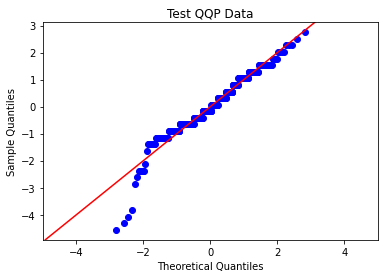

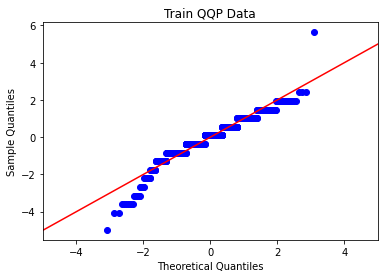

In [8]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

## Stepwise

In [9]:
X = df_X_train_No_ID
y = df_y_train

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

<ipython-input-2-ab5649314316>:137: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  sqft_living15                  with p-value 2.96513e-56
Add  sqft_above                     with p-value 4.97953e-15
Add  grade_8                        with p-value 7.6828e-12
Add  grade_9                        with p-value 4.74867e-15
Add  ZipFirst3_981                  with p-value 4.99466e-07
Add  AgeOfHome                      with p-value 0.000237518
Add  condition_5                    with p-value 0.00520628
Add  grade_10                       with p-value 0.0062092
resulting features:
['sqft_living15', 'sqft_above', 'grade_8', 'grade_9', 'ZipFirst3_981', 'AgeOfHome', 'condition_5', 'grade_10']


## Deep Dive On Residuals

In [10]:
len(df_y_test)

420

Text(0.5, 1.0, 'Residuals PDF')

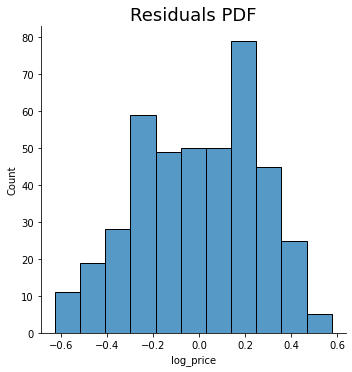

In [11]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [12]:
df_Target_Homes_For_xref.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'AgeOfHome', 'log_price', 'waterfront_1', 'ZipFirst3_981', 'view_1',
       'view_2', 'view_3', 'view_4', 'condition_3', 'condition_4',
       'condition_5', 'grade_7', 'grade_8', 'grade_9', 'grade_10'],
      dtype='object')

In [13]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model1, on="id")

In [14]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(50)
plotHousesWithBigErrors

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10
0,4136880140,254500.0,475526.759428,-221026.759428,221026.759428,86.847450,5/22/2014,254500.0,4,2.75,2570,7264,2.0,1720,850.0,1998,1998.0,98092,47.2580,-122.208,2420,7911,22,12.447056,0,0,0,0,0,0,1,0,0,0,1,0,0
1,8732030490,261500.0,482738.284751,-221238.284751,221238.284751,84.603551,12/22/2014,261500.0,4,2.50,2460,7800,1.0,1500,960.0,1977,1977.0,98023,47.3081,-122.384,2210,7800,43,12.474190,0,0,0,0,0,0,1,0,0,0,1,0,0
2,2413300730,263500.0,476640.395118,-213140.395118,213140.395118,80.888195,9/24/2014,263500.0,4,1.75,2210,6375,1.0,1640,570.0,1977,1977.0,98003,47.3268,-122.328,2070,7210,43,12.481809,0,0,0,0,0,0,1,0,0,0,1,0,0
3,8159300050,355425.0,638786.296595,-283361.296595,283361.296595,79.724639,3/12/2015,355425.0,4,2.50,3238,9112,1.0,1678,1560.0,1979,1979.0,98198,47.4005,-122.311,3056,9668,41,12.781070,0,1,0,1,0,0,0,1,0,0,1,0,0
4,2612000390,269950.0,484800.404293,-214850.404293,214850.404293,79.588963,6/15/2014,269950.0,3,2.50,1890,4838,2.0,1730,160.0,2002,2002.0,98168,47.4802,-122.279,1910,7409,18,12.505992,0,1,0,0,0,0,1,0,0,0,1,0,0
5,9542801310,267000.0,473346.261281,-206346.261281,206346.261281,77.283244,5/13/2015,267000.0,3,2.25,2510,9900,1.0,1610,900.0,1978,1978.0,98023,47.2988,-122.374,1940,8510,42,12.495004,0,0,0,0,0,0,1,0,0,0,1,0,0
6,5137200140,350000.0,608621.404325,-258621.404325,258621.404325,73.891830,3/25/2015,350000.0,4,2.75,2990,11210,1.0,1880,1110.0,1977,1977.0,98023,47.3357,-122.336,2790,9858,43,12.765688,0,0,1,0,0,0,0,1,0,0,1,0,0
7,9264900880,263000.0,455680.609993,-192680.609993,192680.609993,73.262589,7/15/2014,263000.0,3,1.75,1790,7485,1.0,1330,460.0,1979,1979.0,98023,47.3118,-122.340,1970,8097,41,12.479909,0,0,0,0,0,0,0,1,0,0,1,0,0
8,9264910280,280500.0,480622.775014,-200122.775014,200122.775014,71.345018,4/22/2015,280500.0,4,2.75,2660,7754,1.5,1590,1070.0,1986,1986.0,98023,47.3078,-122.337,2250,7754,34,12.544329,0,0,0,0,0,0,1,0,0,0,1,0,0
9,5029460180,260000.0,444351.585282,-184351.585282,184351.585282,70.904456,9/16/2014,260000.0,4,2.75,2250,7345,1.0,1320,930.0,1984,1984.0,98023,47.2895,-122.370,1800,6950,36,12.468437,0,0,0,0,0,0,0,1,0,0,1,0,0


# <u><font color='red'>Model 2</font></u>

## Run Model

In [15]:
# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [16]:
# For SKlearn Model
model2_features_w_id = list(data_Model2.columns).copy()
model2_features_w_id = [e for e in model2_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model2_features_wo_id = list(data_Model2.columns).copy()
model2_features_wo_id = [e for e in model2_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]


In [17]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model2, model2_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

df_Model2_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

978 420 978 420


In [18]:
df_Model2_Results_SK

,Measure,Value
0,train_R2,0.733
1,test_R2,0.720
2,train_mse,0.0268691
3,test_mse,0.028132
4,intercept,12.4515
5,waterfront_1,0.0324603
6,view_1,0.110895
7,view_2,0.0440371
8,view_3,0.101541
9,view_4,0.0426534


In [19]:
df_Model2_Results_Stats, residuals2 = CreateModel_stats (df_y_train ,df_X_train, model2_features_wo_id)
df_Model2_Results_Stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     131.0
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          2.25e-257
Time:                        13:42:18   Log-Likelihood:                 380.88
No. Observations:                 978   AIC:                            -719.8
Df Residuals:                     957   BIC:                            -617.2
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.4515      0.043    292.343      0.000      12.368      12.535
waterfront_1        0.0325      0.173      0.188      0.851      -0.307       0.372
view_1              0.1109      0.040      2.766      0.006       0.032       0.190
view_2              0.0440      0.025      1.734      0.083      -0.006       0.094
view_3              0.1015      0.039      2.620      0.009       0.025       0.178
view_4              0.0427      0.119      0.358      0.720      -0.191       0.276
condition_4         0.0385      0.013      3.018      0.003       0.013       0.064
condition_5         0.0965      0.024      4.104      0.000       0.050       0.143
grade_8             0.1438      0.013     10.652      0.000       0.117       0.170
grade_9             0.2222      0.026      8.621      0.000       0.172       0.273
grade_10            0.1758      0.049      3.614      0.000       0.080       0.271
SchoolDistRank     -0.4650      0.017    -28.066      0.000      -0.498      -0.432
ZipHotnessScore     0.1321      0.032      4.093      0.000       0.069       0.195
Attractions1        0.4281      0.036     11.764      0.000       0.357       0.500
bedrooms           -0.1417      0.059     -2.401      0.017      -0.258      -0.026
bathrooms           0.0228      0.060      0.379      0.705      -0.095       0.141
sqft_lot            0.0904      0.027      3.349      0.001       0.037       0.143
sqft_above          0.5779      0.063      9.120      0.000       0.454       0.702
sqft_basement       0.0885      0.048      1.851      0.064      -0.005       0.182
sqft_living15       0.3366      0.058      5.834      0.000       0.223       0.450
AgeOfHome           0.0226      0.031      0.721      0.471      -0.039       0.084
==============================================================================
Omnibus:                        6.063   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.048   Jarque-Bera (JB):                6.267
Skew:                          -0.142   Prob(JB):                       0.0436
Kurtosis:                       3.270   Cond. No.                         59.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Checking for Homoscedasticity

<ipython-input-2-ab5649314316>:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-2-ab5649314316>:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


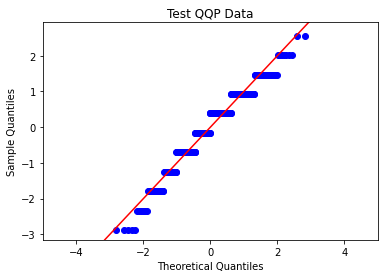

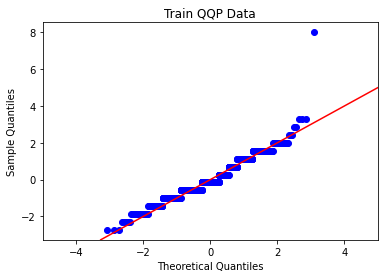

In [20]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

## Stepwise

In [21]:
X = df_X_train_No_ID
y = df_y_train

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

<ipython-input-2-ab5649314316>:137: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  SchoolDistRank                 with p-value 1.54102e-95
Add  sqft_above                     with p-value 2.50559e-85
Add  Attractions1                   with p-value 1.48292e-29
Add  sqft_living15                  with p-value 1.12707e-27
Add  grade_8                        with p-value 1.4977e-13
Add  grade_9                        with p-value 3.38477e-17
Add  sqft_lot                       with p-value 4.63546e-06
Add  ZipHotnessScore                with p-value 5.42952e-05
Add  condition_5                    with p-value 0.000368573
Add  grade_10                       with p-value 0.000567926
Add  condition_4                    with p-value 0.00119034
Add  view_1                         with p-value 0.0055465
Add  view_3                         with p-value 0.00610714
resulting features:
['SchoolDistRank', 'sqft_above', 'Attractions1', 'sqft_living15', 'grade_8', 'grade_9', 'sqft_lot', 'ZipHotnessScore', 'condition_5', 'grade_10', 'condition_4', 'view_1', 'view_3']


## Deep Dive On Residuals

Text(0.5, 1.0, 'Residuals PDF')

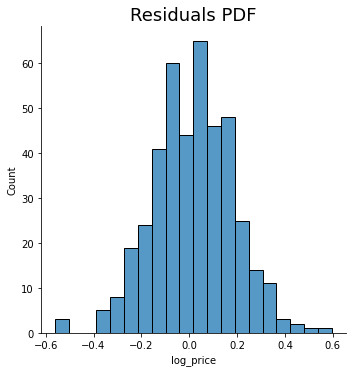

In [22]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [23]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model2, on="id")

In [24]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(5)

# <u><font color='red'>Model 3</font></u>

## Run Model

In [25]:
with open('regression_Data_Third_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [26]:
# For SKlearn Model
model3_features_w_id = list(data_Model3.columns).copy()
model3_features_w_id = [e for e in model3_features_w_id if e not in (meta_data_To_Remove_From_SKmodel)]

# For StatsModel Model
model3_features_wo_id = list(data_Model3.columns).copy()
model3_features_wo_id = [e for e in model3_features_wo_id if e not in (meta_data_To_Remove_From_Statsmodel)]

In [27]:
# 0_X_train, 1_X_test, 2_y_train, 3_y_test, 4_X_train_No_ID, 5_X_test_No_ID)
listOfTrainSplit_Dfs = CreateTrainTestSplit(data_Model3, model3_features_w_id)

df_X_train = listOfTrainSplit_Dfs[0]
df_X_test = listOfTrainSplit_Dfs[1]
df_y_train = listOfTrainSplit_Dfs[2]
df_y_test = listOfTrainSplit_Dfs[3]
df_X_train_No_ID = listOfTrainSplit_Dfs[4]
df_X_test_No_ID = listOfTrainSplit_Dfs[5]

df_Model3_Results_SK, y_hat_train, y_hat_test = CreateModel_SK(df_X_train_No_ID, df_X_test_No_ID, df_y_train, df_y_test)

741 318 741 318


In [28]:
df_Model3_Results_SK

,Measure,Value
0,train_R2,0.855
1,test_R2,0.861
2,train_mse,0.0141833
3,test_mse,0.0139366
4,intercept,12.6307
5,waterfront_1,0
6,view_1,0.0802879
7,view_2,-0.0349718
8,view_3,0.00231665
9,view_4,0.0482356


In [29]:
df_Model3_Results_Stats, residuals3 = CreateModel_stats (df_y_train ,df_X_train, model3_features_wo_id)
df_Model3_Results_Stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     191.9
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          5.08e-283
Time:                        13:42:21   Log-Likelihood:                 525.30
No. Observations:                 741   AIC:                            -1005.
Df Residuals:                     718   BIC:                            -898.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          12.6307      0.053    236.995      0.000      12.526      12.735
waterfront_1                 3.976e-16   3.38e-17     11.778      0.000    3.31e-16    4.64e-16
view_1                          0.0803      0.040      2.029      0.043       0.003       0.158
view_2                         -0.0350      0.028     -1.239      0.216      -0.090       0.020
view_3                          0.0023      0.033      0.070      0.944      -0.063       0.067
view_4                          0.0482      0.125      0.387      0.699      -0.197       0.293
condition_4                    -0.0033      0.011     -0.303      0.762      -0.025       0.018
condition_5                     0.0728      0.021      3.410      0.001       0.031       0.115
grade_8                         0.0467      0.013      3.670      0.000       0.022       0.072
grade_9                         0.0597      0.025      2.404      0.016       0.011       0.108
grade_10                        0.1115      0.042      2.635      0.009       0.028       0.194
AppraisedLandValue              1.2262      0.066     18.558      0.000       1.096       1.356
LandToHouseCheck               -0.3946      0.052     -7.632      0.000      -0.496      -0.293
InflationSinceLastAppraisal     0.0254      0.028      0.921      0.358      -0.029       0.080
SchoolDistRank                 -0.2425      0.017    -14.122      0.000      -0.276      -0.209
ZipHotnessScore                 0.1135      0.031      3.692      0.000       0.053       0.174
Attractions1                    0.1250      0.034      3.722      0.000       0.059       0.191
bedrooms                       -0.0539      0.052     -1.043      0.297      -0.155       0.048
bathrooms                       0.0528      0.050      1.051      0.293      -0.046       0.151
sqft_lot                        0.0158      0.024      0.674      0.501      -0.030       0.062
sqft_above                      0.4019      0.059      6.771      0.000       0.285       0.518
sqft_basement                   0.1185      0.042      2.812      0.005       0.036       0.201
sqft_living15                   0.0090      0.051      0.176      0.860      -0.092       0.110
AgeOfHome                      -0.0403      0.027     -1.504      0.133      -0.093       0.012
==============================================================================
Omnibus:                       27.231   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.632
Skew:                          -0.287   Prob(JB):                     2.03e-10
Kurtosis:                       4.057   Cond. No.                     4.61e+17
==============================================================================

Warnings:
[1] St

## Checking for Homoscedasticity

<ipython-input-2-ab5649314316>:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-2-ab5649314316>:88: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


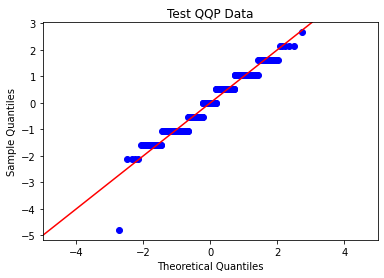

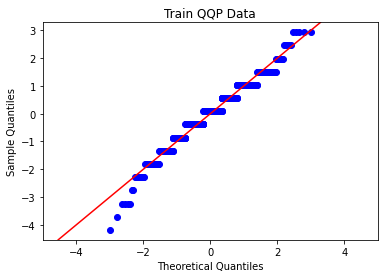

In [30]:
RunQQplot (df_X_test_No_ID, y_hat_test, "Test QQP Data")
RunQQplot (df_X_train_No_ID, y_hat_train, "Train QQP Data")

## Stepwise

In [31]:
X = df_X_train_No_ID
y = df_y_train

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

<ipython-input-2-ab5649314316>:137: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
C:\Users\rgpih\anaconda3a\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\rgpih\anaconda3a\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Add  AppraisedLandValue             with p-value 3.89708e-164
Add  LandToHouseCheck               with p-value 1.13953e-85
Add  SchoolDistRank                 with p-value 1.06847e-30
Add  sqft_above                     with p-value 1.34631e-17
Add  Attractions1                   with p-value 2.24446e-07
Add  sqft_basement                  with p-value 0.000566317
Add  ZipHotnessScore                with p-value 0.00566114
Add  condition_5                    with p-value 0.00306163
resulting features:
['AppraisedLandValue', 'LandToHouseCheck', 'SchoolDistRank', 'sqft_above', 'Attractions1', 'sqft_basement', 'ZipHotnessScore', 'condition_5']


## Deep Dive On Residuals

Text(0.5, 1.0, 'Residuals PDF')

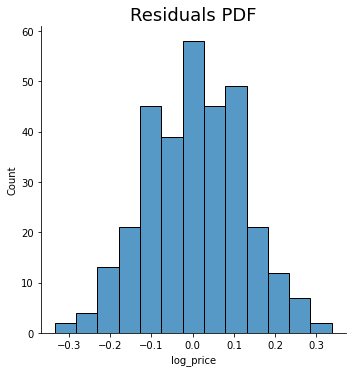

In [32]:
sns.displot(df_y_test-y_hat_test)
plt.title("Residuals PDF", size=18)

Create Dataframe of Residuals to Review For Additional Model Improvement, Looks like current model is over predicting a little more aggresively than under predicting

In [33]:
df_TestResiduals = CheckResiduals (y_hat_test, df_y_test, df_X_test)
CheckForResiduals_No_Dummies = df_TestResiduals.merge(df_Target_Homes_For_xref, on="id")
CheckForResiduals_with_Dummies = df_TestResiduals.merge(data_Model3, on="id")

In [34]:
plotHousesWithBigErrors = CheckForResiduals_No_Dummies.sort_values(by="PercentDiff", ascending=False).head(50)
plotHousesWithBigErrors

,id,Actual,Predictions,Residual,Residual_abs,PercentDiff,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,AgeOfHome,log_price,waterfront_1,ZipFirst3_981,view_1,view_2,view_3,view_4,condition_3,condition_4,condition_5,grade_7,grade_8,grade_9,grade_10
0,5476800069,292050.0,407937.148528,-115887.148528,115887.148528,39.680585,5/27/2014,292050.0,5,3.00,2840,7199,1.0,1710,1130.0,2003,2003.0,98178,47.5065,-122.275,2210,10800,17,12.584680,0,1,0,0,0,0,1,0,0,1,0,0,0
1,2310030500,263000.0,353374.033134,-90374.033134,90374.033134,34.362750,7/10/2014,263000.0,3,1.75,1580,9187,1.0,1180,400.0,1993,1993.0,98038,47.3538,-122.047,1620,6397,27,12.479909,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1133000050,362000.0,478788.582002,-116788.582002,116788.582002,32.262039,4/20/2015,362000.0,4,2.50,2360,7370,1.0,1460,900.0,1985,1985.0,98125,47.7201,-122.308,1590,9906,35,12.799399,0,1,0,0,0,0,1,0,0,1,0,0,0
3,2867300190,363000.0,473268.045763,-110268.045763,110268.045763,30.376872,5/28/2014,363000.0,4,2.50,3753,7204,2.0,3336,417.0,2008,2008.0,98023,47.3011,-122.385,3494,9375,12,12.802158,0,0,0,0,0,0,1,0,0,0,0,0,1
4,8067000020,295000.0,381133.934998,-86133.934998,86133.934998,29.197944,6/11/2014,295000.0,5,3.50,2100,5107,2.0,1410,690.0,1999,1999.0,98178,47.5108,-122.257,1410,5650,21,12.594731,0,1,0,0,0,0,1,0,0,1,0,0,0
5,8159300040,510000.0,364047.405366,145952.594634,145952.594634,28.618156,10/2/2014,510000.0,4,2.75,2730,9112,1.0,1740,990.0,1996,1996.0,98198,47.4005,-122.312,3050,10454,24,13.142166,0,1,0,1,0,0,1,0,0,0,0,1,0
6,3991400080,499900.0,363724.887270,136175.112730,136175.112730,27.240471,12/16/2014,499900.0,3,1.75,2430,8820,1.0,1630,800.0,1977,1977.0,98178,47.4972,-122.233,2390,10050,43,13.122163,0,1,0,1,0,0,1,0,0,0,1,0,0
7,1777600210,590000.0,744993.733740,-154993.733740,154993.733740,26.270124,2/17/2015,590000.0,4,2.25,2530,10611,1.0,1320,1210.0,1977,1977.0,98006,47.5698,-122.132,2530,10125,43,13.287878,0,0,0,0,0,0,0,0,1,0,1,0,0
8,5466420030,253000.0,317296.829877,-64296.829877,64296.829877,25.413767,10/7/2014,253000.0,3,2.50,2020,6564,1.0,1310,710.0,1994,1994.0,98042,47.3545,-122.158,1710,5151,26,12.441145,0,0,0,0,0,0,1,0,0,1,0,0,0
9,2592200030,650000.0,810256.783405,-160256.783405,160256.783405,24.654890,6/18/2014,650000.0,3,1.75,2920,9370,1.0,1620,1300.0,1981,1981.0,98006,47.5491,-122.151,2890,9609,39,13.384728,0,0,0,0,0,0,0,1,0,0,1,0,0


# <u><font color='blue'>3 Models Side By Side</font></u>

In [35]:
listofModels = []
listofModels.append(df_Model1_Results_SK)
listofModels.append(df_Model2_Results_SK)
listofModels.append(df_Model3_Results_SK)
display_side_by_side_withNames(listofModels, names=["Model1", "Model2", "Model3"])

Model1,Model2,Model3
,Measure,Value
0,train_R2,0.391
1,test_R2,0.351
2,train_mse,0.0606455
3,test_mse,0.0664206
4,intercept,12.4926
5,waterfront_1,0.0360163
6,view_1,0.104599
7,view_2,0.0143319
8,view_3,-0.00808237


In [36]:
from statsmodels.stats.stattools import durbin_watson

#perform Durbin-Watson test
resid1 = durbin_watson(residuals1)
resid2 = durbin_watson(residuals2)
resid3 = durbin_watson(residuals3)

df = pd.DataFrame([resid1, resid2,resid3], index =['1', '2', '3'], 
                                              columns =['Durbin-Watson']) 
df 

,Durbin-Watson
1,2.062265
2,2.031626
3,1.990136


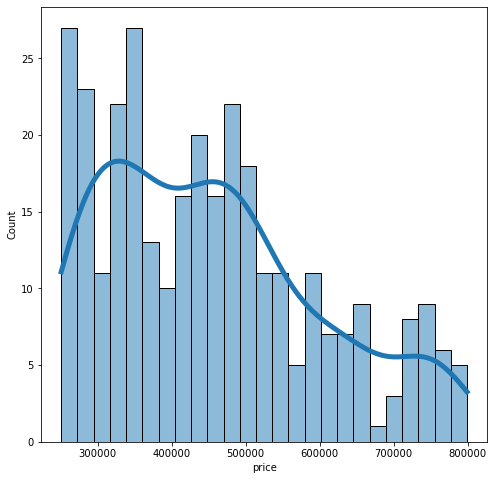

In [37]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "price",
             data=CheckForResiduals_No_Dummies,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax,)
plt.show()

# Cross Validation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

print(cv_5_results.mean())
print(cv_10_results.mean())
print(cv_20_results.mean())

# Misc Code To Keep For Now

In [ ]:
# For Export If Required
# CheckForResiduals_No_Dummies.to_excel("CheckForResiduals_No_Dummies.xlsx")
# CheckForResiduals_with_Dummies.to_excel("CheckForResiduals_with_Dummies.xlsx")

In [ ]:
#for additional chekcing if requires
#df_check2 = CheckForResiduals_No_Dummies.loc[CheckForResiduals_No_Dummies.id ==7950304095]
#df_check2

In [ ]:
# For addiontal chekcing
# import warnings
# warnings.filterwarnings('ignore')
# fig = plt.figure(figsize = (15,15))
# # fig.tight_layout(pad=10.0)
# ax = fig.gca()
# sns.set(font_scale=1)
# plotHousesWithBigErrors.hist(ax = ax, label='small');
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.subplots_adjust(hspace = 0.8)
# plt.show()